Observed data at station: IUANTO at stating time: 2018-09-10T04:19:02.644538Z
1D data at station: IUANTO at stating time: 2018-09-10T04:19:06.900000Z
3D data at station: IUANTO at stating time: 2018-09-10T04:19:05.688750Z


Text(0.5, 0.98, 'Synthetics before processing')

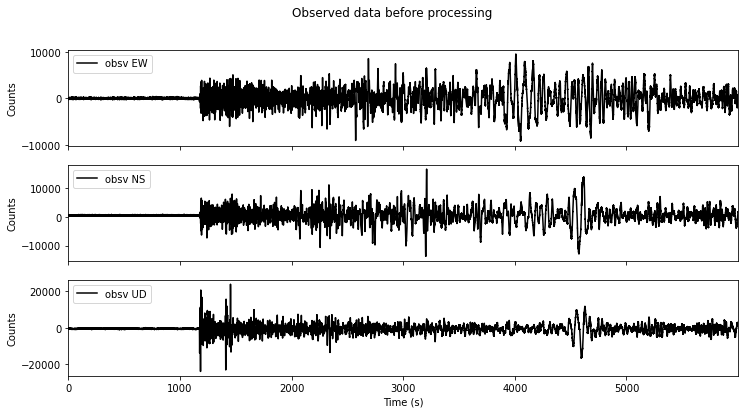

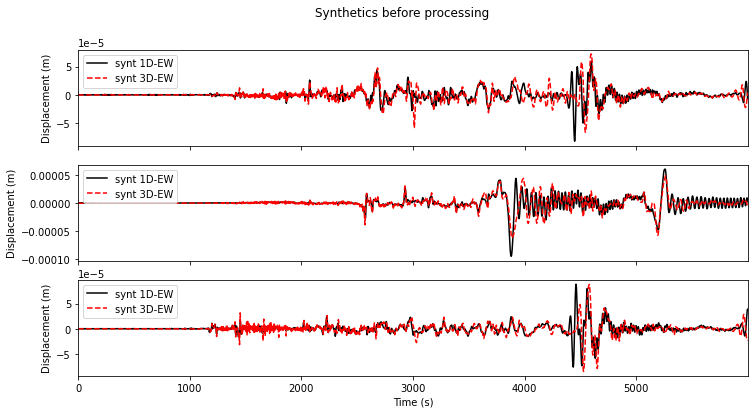

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  6 14:07:56 2022

@author: andreacamilarianoescandon
"""

# Code to preprocess data 
# Comparing observed data and synthetics following steps from ShakeMovie : https://global.shakemovie.princeton.edu/science.jsp
# Synthetic data downloaded from shakemovie

# Observed data: 
# Remove mean and trend, taper, deconvolve instrument response, and apply filter in a certain period band 
# When removing the instrument the following parameters are needed:
# 1. Specify a water level which represents a clipping of the inverse spectrum and limits amplification to a certain
# maximum cut-off value (water_level in dB). 
# 2. Taper the waveform data in the frequency domain prior to multiplying with the inverse spectrum, 
# i.e. perform a pre-filtering in the frequency domain (specifying the four corner frequencies of the frequency taper as a tuple in pre_filt).
# pre_filt (list or tuple(float, float, float, float)) – Apply a bandpass filter in frequency domain to the data before deconvolution. 
# The list or tuple defines the four corner frequencies (f1, f2, f3, f4) of a cosine taper which is one between f2 and f3 and tapers to zero for f1 < f < f2 and f3 < f < f4.

# Synthetics: 
# Remove mean and trend, taper, and apply filter in a certain period band (the filter is the same applied to the observed data)
# filter defined in the pre-filtering of observed data in the frequency domain (specifying the four corner frequencies of the frequency taper as a tuple in pre_filt).

import os 
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
from obspy import read
from obspy.clients.fdsn.client import Client
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy import UTCDateTime

#----------------------------------------------------------------------------------
# Download observed data
#----------------------------------------------------------------------------------

eqname = "C201809100418A"
Download = 0  
quakeml_filename = "quakeml/{}.xml".format(eqname)

def download_events(force_download=False):
    if force_download or not os.path.exists(quakeml_filename):
        cl = Client()
        t1 = UTCDateTime("2018-09-10T00:00:00")
        t2 = UTCDateTime("2018-09-11T00:00:00")

        cat = cl.get_events(starttime=t1, endtime=t2, minmagnitude=6.9,
                            maxmagnitude=7.1)

        os.mkdir("quakeml")
        cat.write(quakeml_filename, "QUAKEML")
    
download_events()
cat = obspy.read_events(quakeml_filename)
pass

def download_data(eqname, t0, lat, lon, min_length=100):
    domain = GlobalDomain()

    restrictions = Restrictions(
        # Get data for a whole year.
        starttime=t0,
        endtime=t0+60*min_length,
        # Chunk it to have one file per day.
        chunklength_in_sec=86400,
        # Considering the enormous amount of data associated with continuous
        # requests, you might want to limit the data based on SEED identifiers.
        # If the location code is specified, the location priority list is not
        # used; the same is true for the channel argument and priority list.
        network="IU", station="*", location="*", channel="BH*",
        # The typical use case for such a data set are noise correlations where
        # gaps are dealt with at a later stage.
        reject_channels_with_gaps=True,
        # Same is true with the minimum length. All data might be useful.
        minimum_length=0.0,
        # Guard against the same station having different names.
        minimum_interstation_distance_in_m=100.0)

    #waveform_dir = 'ObservedData/{}/waveforms'.format(eqname)
    #stationxml_dir = 'ObservedData/{}/stations'.format(eqname)
    #os.mkdir(waveform_dir)
    #os.mkdir(stationxml_dir)

    mdl = MassDownloader(providers=["IRIS"])
    mdl.download(domain, restrictions,
                 mseed_storage='ObservedData/'+eqname+'/Waveform',
                 stationxml_storage='ObservedData/'+eqname+'/Stations')

def process_observed(data,fmin,fmax):
    # Remove mean and the linear trend
    data.detrend("demean")
    data.detrend("linear")
    # Taper
    data.taper(0.05)
    
    # Define a pre-filter and remove the response function
    pre_filt = [0.8*fmin, fmin, fmax, 1.2*fmax]
    data.remove_response(pre_filt=pre_filt, output="DISP",
                         water_level=60, plot=False)
    return data

def sac_taper(tr,fmin,fmax):
    # Remove mean and the linear trend
    tr[0].detrend("demean")
    tr[0].detrend("linear")
    tr[1].detrend("demean")
    tr[1].detrend("linear")
    tr[2].detrend("demean")
    tr[2].detrend("linear")
    # Taper
    tr[0].taper(0.05)
    tr[1].taper(0.05)
    tr[2].taper(0.05)
    # Apply same filter as in observed data 
    pre_filt = [0.8*fmin, fmin, fmax, 1.2*fmax]
    
    for i in [0,1,2]:
        nfft = _npts2nfft(len(tr[i].data))
        data = np.fft.rfft(tr[i].data, nfft)
        fy = 1.0 / (tr[i].stats.delta * 2.0)
        freqs = np.linspace(0, fy, nfft//2+1)
        data *= cosine_sac_taper(freqs, flimit=pre_filt)
        tr[i].data = np.fft.irfft(data)[0:len(tr[i].data)]
    return tr
    
event = cat[0]
origin = event.preferred_origin()

if Download==1:
    download_data(eqname, origin.time, origin.latitude, origin.longitude)


obsd_x = obspy.read("ObservedData/Waveform/IU.ANTO.00.BH1__20180910T041902Z__20180910T055902Z.mseed")[0]
obsd_y = obspy.read("ObservedData/Waveform/IU.ANTO.00.BH2__20180910T041902Z__20180910T055902Z.mseed")[0]
obsd_z = obspy.read("ObservedData/Waveform/IU.ANTO.00.BHZ__20180910T041902Z__20180910T055902Z.mseed")[0]

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].plot(obsd_x.times(), obsd_x.data, "k", label="obsv EW" )
axes[0].set_ylabel("Counts")
axes[1].plot(obsd_y.times(), obsd_y.data, "k", label="obsv NS" )
axes[1].set_ylabel("Counts")
axes[2].plot(obsd_z.times(), obsd_z.data, "k", label="obsv UD" )
axes[2].set_ylabel("Counts")
axes[2].set_xlabel("Time (s)")
axes[0].legend(loc=2)
axes[1].legend(loc=2)
axes[2].legend(loc=2)
axes[2].set_xlim(0, np.max(obsd_x.times()))
fig.suptitle('Observed data before processing',fontsize=12)


# Reading the instrument data
inv = obspy.read_inventory("ObservedData/Stations/IU.ANTO.xml")
obsd_x.attach_response(inv)
obsd_y.attach_response(inv)
obsd_z.attach_response(inv)

#----------------------------------------------------------------------------------
# Load synthetic data
#----------------------------------------------------------------------------------

Data1_x = read('C201809100418A.1D.sac/IU.ANTO.LXE.modes.sac', debug_headers=True)
Data1_y = read('C201809100418A.1D.sac/IU.ANTO.LXN.modes.sac', debug_headers=True)
Data1_z = read('C201809100418A.1D.sac/IU.ANTO.LXZ.modes.sac', debug_headers=True)


Data2_x = read('C201809100418A.3D.sac/IU.ANTO.MXE.sem.sac', debug_headers=True)
Data2_y = read('C201809100418A.3D.sac/IU.ANTO.MXN.sem.sac', debug_headers=True)
Data2_z = read('C201809100418A.3D.sac/IU.ANTO.MXZ.sem.sac', debug_headers=True)

# Merge in one stream to get data 

#obsd_Merged = obsd_x + obsd_y + obsd_z
Data1Merged = Data1_x + Data1_y + Data1_z
Data2Merged = Data2_x + Data2_y + Data2_z

#----------------------------------------------------------------------------------
# Station name and starting time 
#----------------------------------------------------------------------------------
obsd_Network=obsd_x.stats.network
obsd_Station=obsd_x.stats.station
obsd_ST=obsd_x.stats.starttime
obsd_ET=obsd_x.stats.endtime

Data1_Network=Data1_x[0].stats.network
Data1_Station=Data1_x[0].stats.station
Data1_ST=Data1_x[0].stats.starttime
Data1_ET=Data1_x[0].stats.endtime

Data2_Network=Data2_x[0].stats.network
Data2_Station=Data2_x[0].stats.station
Data2_ST=Data2_x[0].stats.starttime
Data2_ET=Data2_x[0].stats.endtime

print('Observed data at station:', obsd_Network+obsd_Station,'at stating time:',obsd_ST)
print('1D data at station:', Data1_Network+Data1_Station,'at stating time:',Data1_ST)
print('3D data at station:', Data2_Network+Data2_Station,'at stating time:',Data2_ST)

#----------------------------------------------------------------------------------
# Time step for each case
#----------------------------------------------------------------------------------
obsd_dt=obsd_x.stats.delta
Data1_dt=Data1_x[0].stats.delta
Data2_dt=Data2_x[0].stats.delta

#----------------------------------------------------------------------------------
# Number of points for each case
#----------------------------------------------------------------------------------
obsd_npts=obsd_x.stats.npts
Data1_npts=Data1_x[0].stats.npts
Data2_npts=Data2_x[0].stats.npts

#----------------------------------------------------------------------------------
# Plots before filtering 
#----------------------------------------------------------------------------------
#obsd_Merged.plot(outfile='A_Observed_beforeProcessing.png',)
Data1Merged.plot(outfile='A_1D_beforeProcessing.png',)
Data2Merged.plot(outfile='A_3D_beforeProcessing.png',)

# Figures
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].plot(Data1Merged[0].times(), Data1Merged[0].data, "k", label="synt 1D-EW" )
axes[0].plot(Data2Merged[0].times(), Data2Merged[0].data, "--r", label="synt 3D-EW")
axes[0].set_ylabel("Displacement (m)")

axes[1].plot(Data1Merged[1].times(), Data1Merged[1].data, "k", label="synt 1D-EW" )
axes[1].plot(Data2Merged[1].times(), Data2Merged[1].data, "--r", label="synt 3D-EW")
axes[1].set_ylabel("Displacement (m)")

axes[2].plot(Data1Merged[2].times(), Data1Merged[2].data, "k", label="synt 1D-EW" )
axes[2].plot(Data2Merged[2].times(), Data2Merged[2].data, "--r", label="synt 3D-EW")
axes[2].set_ylabel("Displacement (m)")
axes[2].set_xlabel("Time (s)")
axes[2].set_xlim(0, np.max([(np.max(Data1Merged[0].times()),np.max(Data2Merged[0].data))]))

axes[0].legend(loc=2)
axes[1].legend(loc=2)
axes[2].legend(loc=2)
fig.suptitle('Synthetics before processing',fontsize=12)

In [2]:
#----------------------------------------------------------------------------------
# Resample and cutting signal to a common window (Resample at 1Hz)
#----------------------------------------------------------------------------------
print('Stream data before resampling-----------------------------------------------')
#print(obsd_Merged)
print(Data1Merged)
print(Data2Merged)

# Cut signal to common starting time and end time
Common_startime=np.max([obsd_ST,Data1_ST,Data2_ST])
Common_endtime=np.min([obsd_ET,Data1_ET,Data1_ET])
obsd_x.trim(Common_startime,Common_endtime)
obsd_y.trim(Common_startime,Common_endtime)
obsd_z.trim(Common_startime,Common_endtime)
Data1Merged.trim(Common_startime,Common_endtime)
Data2Merged.trim(Common_startime,Common_endtime)

# Resample
fstep=1
obsd_x.resample(fstep)  
obsd_y.resample(fstep) 
obsd_z.resample(fstep) 
Data1Merged.resample(fstep)  
Data2Merged.resample(fstep)  

print('Stream data after resampling-----------------------------------------------')
print(Data1Merged)
print(Data2Merged)

Stream data before resampling-----------------------------------------------
3 Trace(s) in Stream:
IU.ANTO.S1.LXE | 2018-09-10T04:19:06.900000Z - 2018-09-10T05:59:04.900000Z | 0.5 Hz, 3000 samples
IU.ANTO.S1.LXN | 2018-09-10T04:19:06.900000Z - 2018-09-10T05:59:04.900000Z | 0.5 Hz, 3000 samples
IU.ANTO.S1.LXZ | 2018-09-10T04:19:06.900000Z - 2018-09-10T05:59:04.900000Z | 0.5 Hz, 3000 samples
3 Trace(s) in Stream:
IU.ANTO.S3.MXE | 2018-09-10T04:19:05.688750Z - 2018-09-10T05:59:29.477389Z | 6.2 Hz, 37300 samples
IU.ANTO.S3.MXN | 2018-09-10T04:19:05.688750Z - 2018-09-10T05:59:29.477389Z | 6.2 Hz, 37300 samples
IU.ANTO.S3.MXZ | 2018-09-10T04:19:05.688750Z - 2018-09-10T05:59:29.477389Z | 6.2 Hz, 37300 samples
Stream data after resampling-----------------------------------------------
3 Trace(s) in Stream:
IU.ANTO.S1.LXE | 2018-09-10T04:19:06.900000Z - 2018-09-10T05:59:03.900000Z | 1.0 Hz, 5998 samples
IU.ANTO.S1.LXN | 2018-09-10T04:19:06.900000Z - 2018-09-10T05:59:03.900000Z | 1.0 Hz, 5998 sa

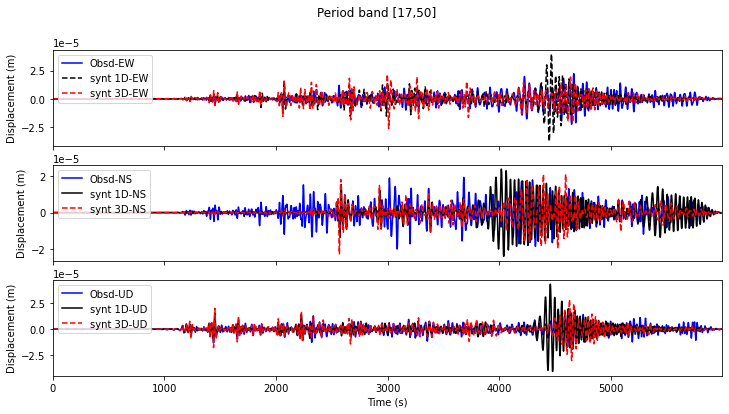

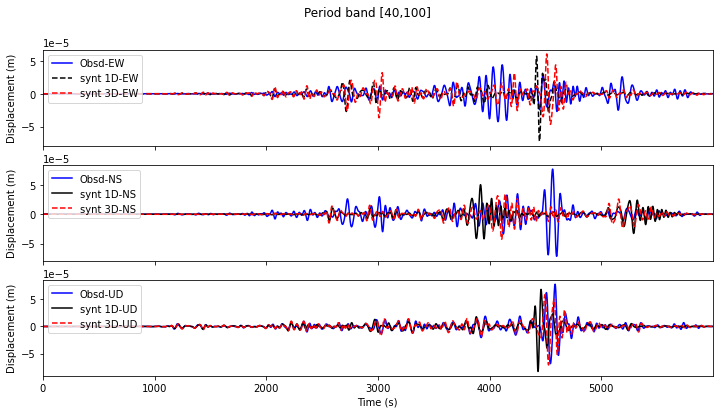

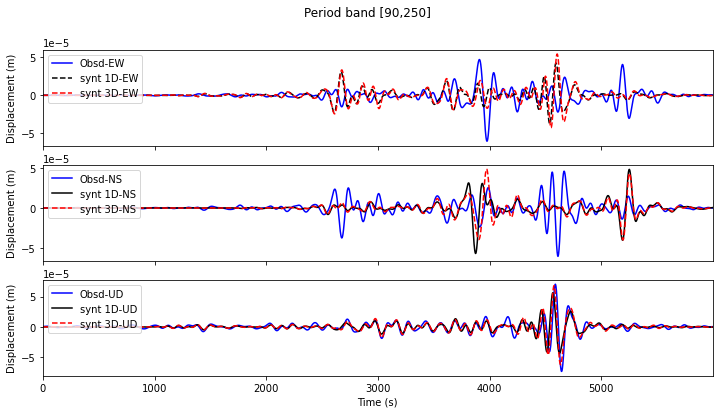

In [3]:
#----------------------------------------------------------------------------------
# Remove the trend and mean from the the observed and synthetic records and taper them.
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Remove the instrument response from the observed seismograms (recommended) or convolve the synthetic seismograms with the instrument response.
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Filtering signals 
#----------------------------------------------------------------------------------
# Make sure that you apply the exact same filtering operations to both observed 
# and synthetic seismograms. Preferably, avoid filtering your records more than once, 
# and if you do filter more than once, make sure you filter both the data and the 
# synthetics with the same filter, such that data and synthetics are always subjected 
# to the same filtering operations.

Tmin1,Tmax1 = 17, 50
Tmin2,Tmax2 = 40, 100
Tmin3,Tmax3 = 90, 250


for i in [1,2,3]:
    if i == 1 :  
        tmin=Tmin1
        tmax=Tmax1
        obsd_x_filt=obsd_x.copy()
        obsd_y_filt=obsd_y.copy()
        obsd_z_filt=obsd_z.copy()
        Data1_filt=Data1Merged.copy()
        Data2_filt=Data2Merged.copy()
    elif i == 2 : 
        tmin=Tmin2
        tmax=Tmax2
        obsd_x_filt=obsd_x.copy()
        obsd_y_filt=obsd_y.copy()
        obsd_z_filt=obsd_z.copy()
        Data1_filt=Data1Merged.copy()
        Data2_filt=Data2Merged.copy()
    elif i == 3 : 
        tmin=Tmin3
        tmax=Tmax3
        obsd_x_filt=obsd_x.copy()
        obsd_y_filt=obsd_y.copy()
        obsd_z_filt=obsd_z.copy()
        Data1_filt=Data1Merged.copy()
        Data2_filt=Data2Merged.copy()
    
    freqmin=1/tmax
    freqmax=1/tmin

    process_observed(obsd_x_filt,freqmin,freqmax)
    process_observed(obsd_y_filt,freqmin,freqmax)
    process_observed(obsd_z_filt,freqmin,freqmax)
    sac_taper(Data1_filt,freqmin,freqmax)
    sac_taper(Data2_filt,freqmin,freqmax)

    fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
    axes[0].plot(obsd_x_filt.times(), obsd_x_filt.data, "b", label='Obsd-EW')
    axes[0].plot(Data1_filt[0].times(), Data1_filt[0].data, "--k", label='synt 1D-EW')
    axes[0].plot(Data2_filt[0].times(), Data2_filt[0].data, "--r", label='synt 3D-EW')
    axes[0].set_ylabel("Displacement (m)")

    axes[1].plot(obsd_y_filt.times(), obsd_y_filt.data, "b", label='Obsd-NS')
    axes[1].plot(Data1_filt[1].times(), Data1_filt[1].data, "k", label='synt 1D-NS')
    axes[1].plot(Data2_filt[1].times(), Data2_filt[1].data, "--r", label='synt 3D-NS')
    axes[1].set_ylabel("Displacement (m)")

    axes[2].plot(obsd_z_filt.times(), obsd_z_filt.data, "b", label='Obsd-UD')
    axes[2].plot(Data1_filt[2].times(), Data1_filt[2].data, "k", label='synt 1D-UD')
    axes[2].plot(Data2_filt[2].times(), Data2_filt[2].data, "--r", label='synt 3D-UD')
    axes[2].set_ylabel("Displacement (m)")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_xlim(0, np.max([(np.max(Data1Merged[0].times()),np.max(Data2Merged[0].data))]))
   
    axes[0].legend(loc=2)
    axes[1].legend(loc=2)
    axes[2].legend(loc=2)
    fig.suptitle('Period band ['+str(tmin)+','+str(tmax)+']',fontsize=12)
            
#----------------------------------------------------------------------------------
# END 
#----------------------------------------------------------------------------------